In [34]:
import pandas as pd, numpy as np, sqlite3, os, os.path, tempfile, time, matplotlib.pyplot as plt,seaborn as sns

# Wstęp

W poniższym raporcie z czwartej pracy domowej z przedmiotu Przetwarzanie Danych Ustrukturyzowanych na II semestrze kierunku Inżynieria i Analiza Danych w roku akademickim 2020/2021 zostanie przedstawione porównanie wydajności i wyników zapytań SQL i ich odpowiedników napisanych z pomocą pakietu Pandas. Dane, tak jak w drugiej pracy domowej, pochodzą z serwisu https://travel.stackexchange.com/

# Wczytanie danych

In [3]:
Badges = pd.read_csv("travel_stackexchange_com/Badges.csv.gz", compression = 'gzip')
Comments = pd.read_csv("travel_stackexchange_com/Comments.csv.gz", compression = 'gzip')
PostLinks = pd.read_csv("travel_stackexchange_com/PostLinks.csv.gz", compression = 'gzip')
Posts = pd.read_csv("travel_stackexchange_com/Posts.csv.gz", compression = 'gzip')
Tags = pd.read_csv("travel_stackexchange_com/Tags.csv.gz", compression = 'gzip')
Users = pd.read_csv("travel_stackexchange_com/Users.csv.gz", compression = 'gzip')
Votes = pd.read_csv("travel_stackexchange_com/Votes.csv.gz", compression = 'gzip')

# Utworzenie bazy danych

In [5]:
db = os.path.join(tempfile.mkdtemp(),'travelse.db')
if os.path.isfile(db):
    os.remove(db)
conn = sqlite3.connect(db)
Badges.to_sql("Badges", conn)
Comments.to_sql("Comments", conn)
PostLinks.to_sql("PostLinks", conn)
Posts.to_sql("Posts", conn)
Tags.to_sql("Tags", conn)
Users.to_sql("Users", conn)
Votes.to_sql("Votes", conn)

# Rozwiązania

## Zadanie 1

Wybieramy 10 najczęściej występujących tagów.

### Rozwiązanie referencyjne

In [41]:
def sql_1():
    return pd.read_sql_query("""
    SELECT TagName, Count
    FROM Tags
    ORDER BY Count DESC
    LIMIT 10
    """,conn)
start = time.time()
df_sql_1 = sql_1()
stop = time.time()
sql_1_time = stop - start
df_sql_1

,TagName,Count
0,visas,5271
1,usa,2858
2,air-travel,2830
3,uk,2114
4,schengen,2094
5,customs-and-immigration,1798
6,transit,1204
7,trains,1031
8,passports,954
9,indian-citizens,916


### Rozwiązanie Pandas

In [42]:
def pd_1():
    return Tags.loc[:,["TagName","Count"]].sort_values("Count",ascending = False).head(10).reset_index(drop=True)
start = time.time()
df_pd_1 = pd_1()
stop = time.time()
pd_1_time = stop - start
df_pd_1

,TagName,Count
0,visas,5271
1,usa,2858
2,air-travel,2830
3,uk,2114
4,schengen,2094
5,customs-and-immigration,1798
6,transit,1204
7,trains,1031
8,passports,954
9,indian-citizens,916


### Sprawdzenie poprawności i prędkości

True


A:\Inzynieria_i_Analiza_Danych_PW\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

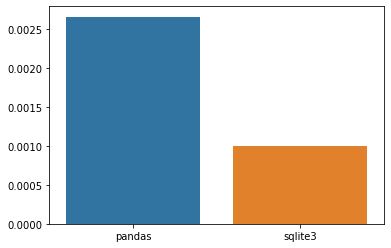

In [43]:
print(df_pd_1.equals(df_sql_1))
sns.barplot(["pandas","sqlite3"],[pd_1_time,sql_1_time])

**Wnioski**

W przypadku mało złożonego zapytania rozwiązanie referencyjne wykonuje się około 2 razy szybciej niż to uzyskane za pomocą pakietu pandas. Oba czasy wykonania są jednak tak niewielkie, że w grę wchodzi tu margines błędu pomiarowego.




## Zadanie 2


Z tabeli Comments wybieramy PostID, UserID oraz sumę kolumny Score, ozn. CommentsTotalScore, pogrupowane kolejno po PostID i UserID. W wyniku tych operacji otrzymujemy tabelę, którą oznaczamy jako CmtTotScr. 

Łączymy CmtTotScr z Posts po ID postów, biorąc pod uwagę jedynie posty będące pytaniami (o PostTypeId równym 1). Z połączonej tabeli wybieramy kolumny Posts.Title, Posts.CommentCount, CmtTotScr.CommentsTotalScore, Posts.ViewCount, a następnie sortujemy malejąco względem wartości zmiennej CmtTotScr.CommentsTotalScore i wybieramy pierwsze 10 rekordów. 

Oznacza to że wybieramy 10 pytań, których komentarze mają największą sumę punktów (czy też "łapek w górę").

### Rozwiązanie referencyjne

In [46]:
def sql_2():
    return pd.read_sql_query("""
SELECT
    Posts.Title, Posts.CommentCount,
    CmtTotScr.CommentsTotalScore,
    Posts.ViewCount
FROM (
        SELECT
            PostID,
            UserID,
            SUM(Score) AS CommentsTotalScore
        FROM Comments
        GROUP BY PostID, UserID
) AS CmtTotScr
JOIN Posts ON Posts.ID=CmtTotScr.PostID
WHERE Posts.PostTypeId=1
ORDER BY CmtTotScr.CommentsTotalScore DESC
LIMIT 10
""",conn)
start = time.time()
df_sql_2 = sql_2()
stop = time.time()
sql_2_time = stop - start
df_sql_2

,Title,CommentCount,CommentsTotalScore,ViewCount
0,"Boss is asking for passport, but it has a stam...",24,207,54982.0
1,Why don't airlines have backup planes just in ...,26,172,14516.0
2,"OK we're all adults here, so really, how on ea...",27,155,73808.0
3,How to cross a road by foot in a country that ...,25,140,5240.0
4,Where can I change my clothes at the airport?,16,128,12020.0
5,"Boss is asking for passport, but it has a stam...",24,121,54982.0
6,How to avoid toddlers on a long-distance plane...,19,120,24955.0
7,Job interview in London requires me to wire mo...,23,116,14827.0
8,What to do without underwear on a 4 day trip?,13,110,11713.0
9,"OK, we are all adults here, so what is a bidet...",28,109,52265.0


### Rozwiązanie Pandas

In [92]:
def pd_2():
    CmtTotScr = Comments.loc[:,["PostId","UserId","Score"]].groupby(["PostId","UserId"]).sum("Score").reset_index()
    CmtTotScr.columns = ["PostId","UserId","CommentsTotalScore"]
    df1 = CmtTotScr.merge(Posts,left_on='PostId',right_on='Id')
    return df1[df1.PostTypeId == 1].sort_values('CommentsTotalScore',ascending = False).loc[:,['Title','CommentCount','CommentsTotalScore','ViewCount']].head(10).reset_index(drop = True)
start = time.time()
df_pd_2 = pd_2()
stop = time.time()
pd_2_time = stop - start
df_pd_2

,Title,CommentCount,CommentsTotalScore,ViewCount
0,"Boss is asking for passport, but it has a stam...",24,207,54982.0
1,Why don't airlines have backup planes just in ...,26,172,14516.0
2,"OK we're all adults here, so really, how on ea...",27,155,73808.0
3,How to cross a road by foot in a country that ...,25,140,5240.0
4,Where can I change my clothes at the airport?,16,128,12020.0
5,"Boss is asking for passport, but it has a stam...",24,121,54982.0
6,How to avoid toddlers on a long-distance plane...,19,120,24955.0
7,Job interview in London requires me to wire mo...,23,116,14827.0
8,What to do without underwear on a 4 day trip?,13,110,11713.0
9,"OK, we are all adults here, so what is a bidet...",28,109,52265.0


### Sprawdzenie poprawności i prędkości

True


A:\Inzynieria_i_Analiza_Danych_PW\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

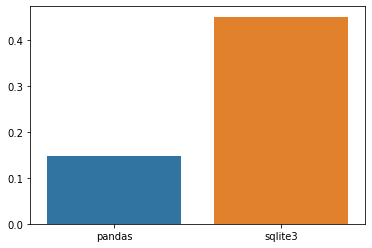

In [93]:
print(df_pd_2.equals(df_sql_2))
sns.barplot(["pandas","sqlite3"],[pd_2_time,sql_2_time])

**Wnioski**

Widzimy, że, przy bardziej złożonym zapytaniu, pandas działa znacząco szybciej niż rozwiązanie referencyjne. Zapewne wynika to w jakimś stopniu z czasu dostępu do tymczasowej bazy danych, jednak godna uwagi jest też prędkość działania operacji na DataFrame'ach. Razem zajmuje to mniej niż 0.2 sekundy, co jest zadowalającym wynikiem jak na tabelę zawierającą ponad 150 tysięcy rekordów.

# Podsumowanie


Pakiet Pandas zapewnia wysoką wydajność m.in. w zastosowaniach bazodanowych. Zwięzłość kodu i rozbudowane funkcje stanowią niezaprzeczalne plusy tej biblioteki.

In [95]:
conn.close()